In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning Analysis

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import joblib

from utils.helper_functions import split_data

In [43]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))

In [44]:
train_df, val_df, test_df = split_data(cancer_df)

In [45]:
train_df.loc[:, numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df.loc[:, numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df.loc[:, numeric_cols] = scaler.transform(test_df[numeric_cols])

In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

def create_pipeline(model_args = {}):
    """
    Create a pipeline with the given model.
    """
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.compose import TransformedTargetRegressor

    preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), numeric_cols)
            ],
            remainder='passthrough',
            force_int_remainder_cols=False
        )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', TransformedTargetRegressor(
            regressor=RandomForestRegressor(**model_args),
            transformer=FunctionTransformer(np.log1p, inverse_func=np.expm1)
        ))
    ])
    return pipeline

In [49]:
from utils.helper_functions import plot_regression_results_sklearn, get_features_and_target


model_args = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "random_state": 42
}
model = create_pipeline(model_args)
train_features, train_target = get_features_and_target(train_df)
model.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['SMOKING_PACK_YEARS',
                                                   'CNA_CSMD2', 'CNA_MACF1',
                                                   'CNA_LRRC7', 'CNA_C1orf173',
                                                   'CNA_COL11A1', 'CNA_FLG',
                                                   'CNA_SPTA1', 'CNA_TNN',
                                                   'CNA_TNR', 'CNA_PAPPA2',
                                                   'CNA_ASTN1', 'CNA_CACNA1E',
                                                   'CNA_HMCN1', 'CNA_USH2A',
                                                   'CNA_OBSCN',...
                                                   'CNA_FMN2', 'CNA_NLRP3',
                                                   'CNA_APOB', 'CNA_NRXN1',
                                                   'CNA_CNTNAP5', 'CNA_LRP1B',
                                                   'CNA_NEB', 'CNA_XIRP2',
                                                   'CNA_LRP2', 'CNA_TTN',
                                                   'CNA_ZNF804A', 'CNA_DNAH7',
                                                   'CNA_SPHKAP', ...])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=10,
                                                                            max_features='sqrt',
                                                                            random_state=42),
                                            transformer=FunctionTransformer(func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)))])

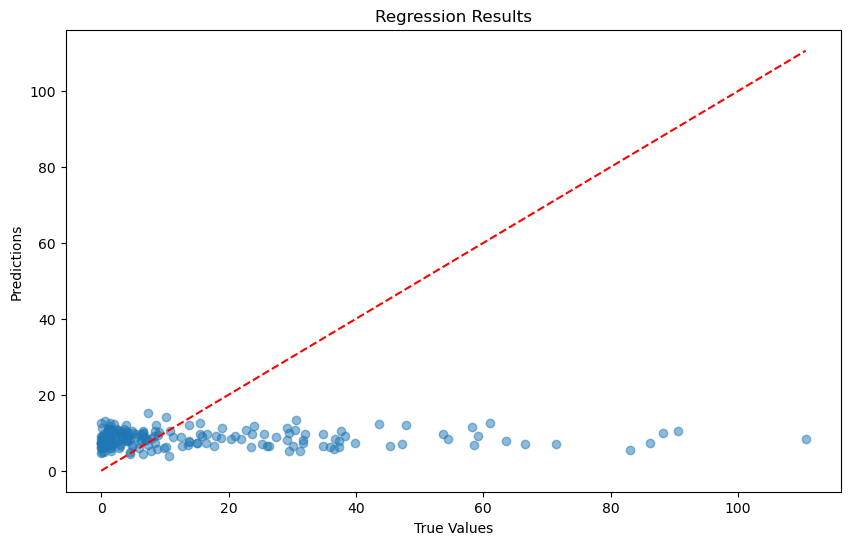

In [50]:
plot_regression_results_sklearn(model, test_df)

In [57]:
import optuna
from sklearn.metrics import mean_squared_error

def objective(trial : optuna.Trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 400)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 40)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 40)
    model = create_pipeline({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "random_state": 42
        })
    train_features, train_target = get_features_and_target(train_df)
    val_features, val_target = get_features_and_target(val_df)


    model.fit(train_features, train_target)
    mse = mean_squared_error(val_target, model.predict(val_features))
    return  mse


In [58]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="rf_study")
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-14 15:53:41,652] A new study created in memory with name: rf_study


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-14 15:53:46,804] Trial 13 finished with value: 795.649191397212 and parameters: {'n_estimators': 78, 'max_depth': 341, 'min_samples_split': 19, 'min_samples_leaf': 29}. Best is trial 13 with value: 795.649191397212.
[I 2025-04-14 15:53:47,152] Trial 12 finished with value: 796.3201364059488 and parameters: {'n_estimators': 80, 'max_depth': 308, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 13 with value: 795.649191397212.
[I 2025-04-14 15:53:51,245] Trial 2 finished with value: 798.1684218650157 and parameters: {'n_estimators': 251, 'max_depth': 30, 'min_samples_split': 29, 'min_samples_leaf': 9}. Best is trial 13 with value: 795.649191397212.
[I 2025-04-14 15:53:52,508] Trial 1 finished with value: 795.7706143964011 and parameters: {'n_estimators': 305, 'max_depth': 267, 'min_samples_split': 20, 'min_samples_leaf': 20}. Best is trial 13 with value: 795.649191397212.
[I 2025-04-14 15:53:54,574] Trial 16 finished with value: 794.9952962016839 and parameters: {

In [59]:
best_model = create_pipeline(study.best_trial.params)
train_features, train_target = get_features_and_target(train_df)
best_model.fit(train_features, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['SMOKING_PACK_YEARS',
                                                   'CNA_CSMD2', 'CNA_MACF1',
                                                   'CNA_LRRC7', 'CNA_C1orf173',
                                                   'CNA_COL11A1', 'CNA_FLG',
                                                   'CNA_SPTA1', 'CNA_TNN',
                                                   'CNA_TNR', 'CNA_PAPPA2',
                                                   'CNA_ASTN1', 'CNA_CACNA1E',
                                                   'CNA_HMCN1', 'CNA_USH2A',
                                                   'CNA_OBSCN',...
                                                   'CNA_FMN2', 'CNA_NLRP3',
                                                   'CNA_APOB', 'CNA_NRXN1',
                                                   'CNA_CNTNAP5', 'CNA_LRP1B',
                                                   'CNA_NEB', 'CNA_XIRP2',
                                                   'CNA_LRP2', 'CNA_TTN',
                                                   'CNA_ZNF804A', 'CNA_DNAH7',
                                                   'CNA_SPHKAP', ...])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=242,
                                                                            min_samples_split=9,
                                                                            n_estimators=999),
                                            transformer=FunctionTransformer(func=<ufunc 'log1p'>,
                                                                            inverse_func=<ufunc 'expm1'>)))])

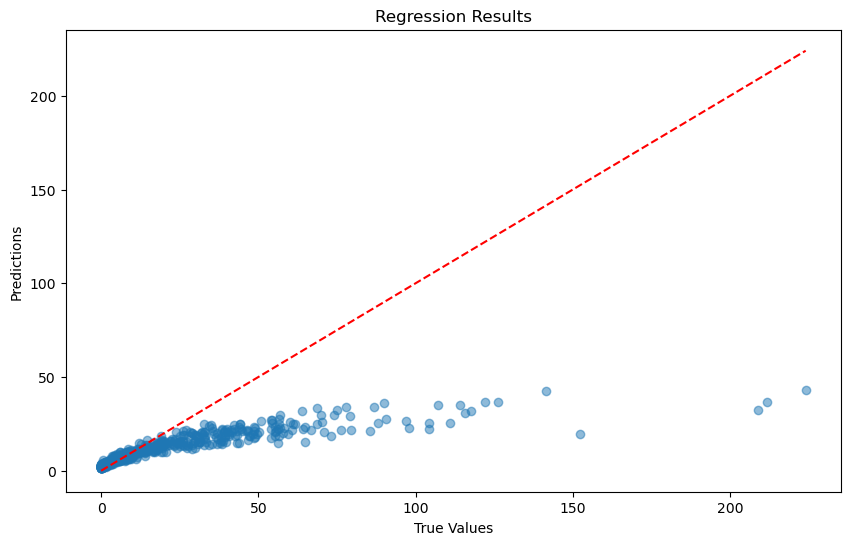

In [60]:
plot_regression_results_sklearn(best_model, train_df)
